<a href="https://colab.research.google.com/github/qihang-dai/Double-Machine-Learning/blob/master/Project_Cassava_Leaf_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS519 Project - Cassava Leaf Image Classification


## Setup

In [ ]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import os

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch 
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torchvision.models as M
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from PIL import Image
import random

For the data, you need to agree to the terms and conditions to the Kaggle competition and click download all at https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data.

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

In [ ]:
# Print labels and category encodings
train = pd.read_csv('drive/MyDrive/CIS519_Project/dataset/train.csv')
test = pd.read_csv('drive/MyDrive/CIS519_Project/dataset/sample_submission.csv')
label_map = pd.read_json('drive/MyDrive/CIS519_Project/dataset/label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


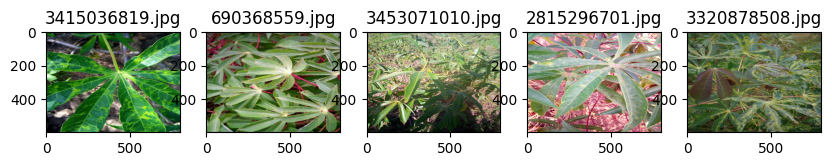

In [ ]:
# Visualize raw images
image_dir = 'drive/MyDrive/CIS519_Project/dataset/train_images'
image_files = os.listdir(image_dir)
num_images = 5
sample_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(1, num_images, figsize=(10, 5))
for i, image_file in enumerate(sample_images):
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    axs[i].imshow(image)
    axs[i].set_title(image_file)
plt.show()

## 1. Baseline

### 1.1 Implementation (Ruichen)

In [ ]:
# Use pretrained ResNet as baseline
resnet = M.resnet50(pretrained=True)
# print(resnet) # model architecture
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
# Define basic transformation and augmentation
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

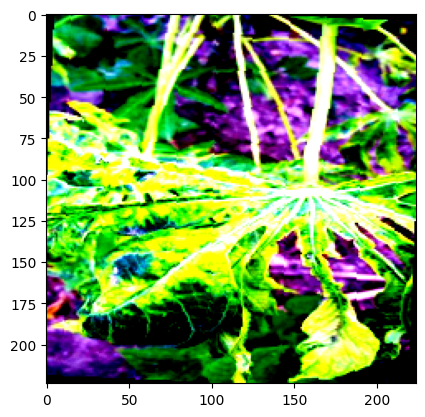

In [ ]:
# Visualize transformed image
sample_image_path = 'drive/MyDrive/CIS519_Project/dataset/train_images/6103.jpg'
sample_image = Image.open(sample_image_path)
transformed_image = transform(sample_image)

plt.imshow(transformed_image.permute(1, 2, 0))
plt.show()

In [ ]:
# Load images and labels
class CassavaDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.csv_path = csv_path
        self.image_dir = image_dir
        self.transform = transform
        self.data = pd.read_csv(csv_path)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = os.path.join(self.image_dir, row['image_id'])
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = row['label']
        return image, label


# Train test split
num_train = int(len(dataset) * 0.7)
num_val = int(len(dataset) * 0.15)
num_test = len(dataset) - num_train - num_val
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

FileNotFoundError: ignored

### 1.2 Evalutation (Alan)

## 2. Fine-tuning Kaggle Solution

### 2.1 Implementation (Qihang)

### 2.2 Evaluation (Alan)